In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_german = pd.read_csv('/content/drive/MyDrive/Mestrado/Intro - Aprendizado Máquina/tp3/german.csv')

In [3]:
from sklearn.model_selection import train_test_split, LearningCurveDisplay, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

In [4]:
minmax = MinMaxScaler()
x = minmax.fit_transform(df_german.iloc[:, 0:-1])
y = df_german.iloc[:, -1]

In [5]:
x_tt, x_valid, y_tt, y_valid = train_test_split(x, y, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_tt, y_tt, test_size=0.25)

## Ensembles

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [9]:
learn_curve_params = {
    "X": x_tt,
    "y": y_tt,
    "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "score_name": "Accuracy"
}

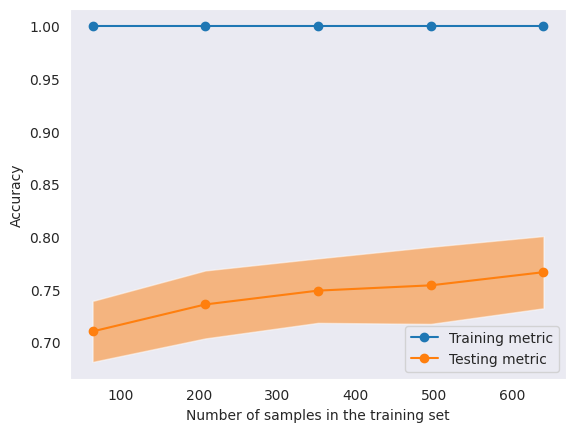

In [10]:
rf = RandomForestClassifier(criterion='entropy')
LearningCurveDisplay.from_estimator(rf, **learn_curve_params);

In [11]:
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.76      0.95      0.85       136
           2       0.77      0.38      0.51        64

    accuracy                           0.77       200
   macro avg       0.77      0.66      0.68       200
weighted avg       0.77      0.77      0.74       200



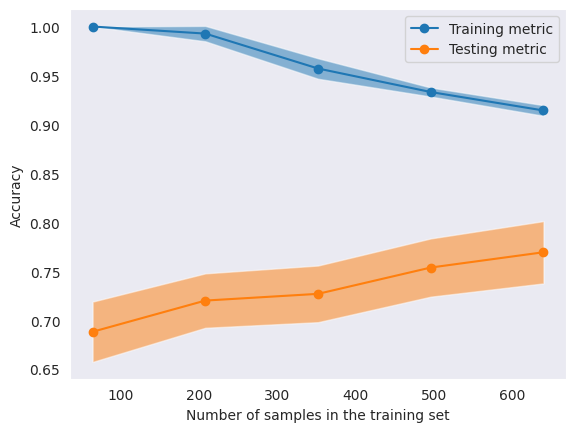

In [12]:
gb = GradientBoostingClassifier()
LearningCurveDisplay.from_estimator(gb, **learn_curve_params);

In [13]:
gb.fit(x_train, y_train)
y_pred = gb.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.79      0.91      0.85       136
           2       0.73      0.50      0.59        64

    accuracy                           0.78       200
   macro avg       0.76      0.71      0.72       200
weighted avg       0.77      0.78      0.77       200



## Redes Neurais

In [8]:
# Possibilita a utilização do searchgrid so sklearn
!pip install scikeras

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [45]:
def nn_model(learning_rate, momentum, optimizer, neurons, activation, input_dim):
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_dim, activation=activation))
    model.add(Dense(1, activation=activation))
    if optimizer().name != 'Adam':
        opt = optimizer(learning_rate=learning_rate, momentum=momentum)
    else:
        opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

model = KerasClassifier(model=nn_model, epochs=30, verbose=0)

nn_params = {
    'model__learning_rate': [0.001, 0.01, 0.1],
    'model__momentum': [0.0, 0.01, 0.1],
    'model__optimizer': [Adam, SGD, RMSprop],
    'model__neurons': [16, 32, 64, 128],
    'model__activation': ['relu', 'sigmoid'],
    'model__input_dim': [x_valid.shape[1]]
}

grid = GridSearchCV(estimator=model, param_grid=nn_params, scoring='accuracy', cv=3)
grid_result = grid.fit(x_valid, y_valid)

In [46]:
print(f'Best score: {grid_result.best_score_}\nBest params: {grid_result.best_params_}')

Best score: 0.7798884366048545
Best params: {'model__activation': 'sigmoid', 'model__input_dim': 24, 'model__learning_rate': 0.001, 'model__momentum': 0.01, 'model__neurons': 32, 'model__optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>}


In [14]:
# Best model
bd_model = nn_model(learning_rate=0.001, momentum=0.01, optimizer=RMSprop, neurons=32, activation='sigmoid', input_dim=x_train.shape[1])
model = KerasClassifier(model=bd_model, epochs=30, verbose=0)
model.fit(x_train, y_train)

KerasClassifier(
	model=<keras.src.engine.sequential.Sequential object at 0x7dbed8086a70>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=30
	class_weight=None
)

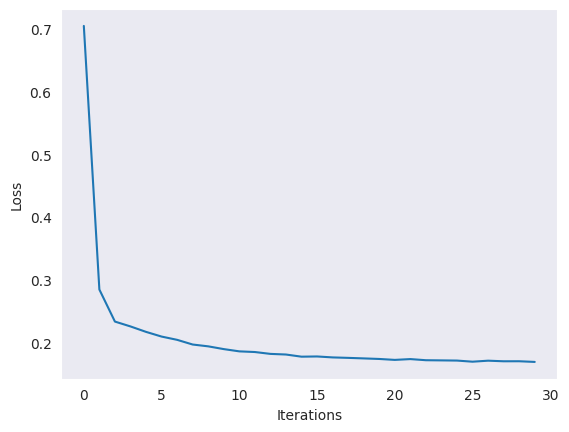

In [21]:
plt.plot(range(0, 30), model.history_['loss'])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [22]:
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.80      0.93      0.86       143
           2       0.70      0.40      0.51        57

    accuracy                           0.78       200
   macro avg       0.75      0.67      0.68       200
weighted avg       0.77      0.78      0.76       200



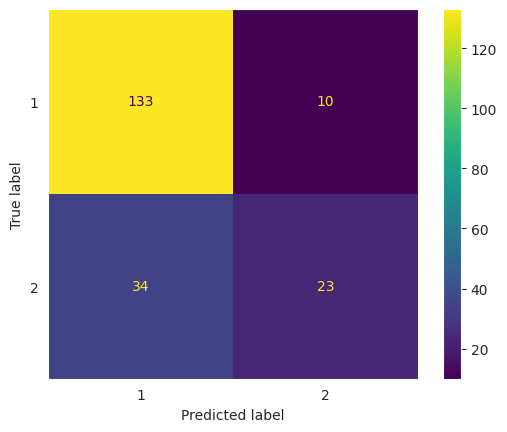

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
mtx = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
mtx.plot();